In [20]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from collections import OrderedDict

import matplotlib.pyplot as plt

import numpy as np

import nibabel as nib

from typing import Callable, Any, Optional, List

import os
import time

Tesla T4
PyTorch Version: 1.8.1
CuDNN Version: 8005
gpu usage (current/max): 1.12 / 2.39 GB


In [8]:
#Atrous Spatial Pyramid Pooling (Segmentation Network)
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv3d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            #nn.AdaptiveAvgPool2d(1),
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-3:]
        x = F.adaptive_avg_pool3d(x,(1))
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='nearest')#, align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv3d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)   


In [9]:
#Mobile-Net with depth-separable convolutions and residual connections
class ResBlock(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs
    
in_channels = torch.Tensor([1,16,24,24,32,32,32,64]).long()
mid_channels = torch.Tensor([32,96,144,144,192,192,192,384]).long()
out_channels = torch.Tensor([16,24,24,32,32,32,64,64]).long()
mid_stride = torch.Tensor([1,1,1,1,1,2,1,1])

net = []
net.append(nn.Identity())
for i in range(len(in_channels)):
    inc = int(in_channels[i]); midc = int(mid_channels[i]); outc = int(out_channels[i]); strd = int(mid_stride[i])
    layer = nn.Sequential(nn.Conv3d(inc,midc,1,bias=False),nn.BatchNorm3d(midc),nn.ReLU6(True),\
                    nn.Conv3d(midc,midc,3,stride=strd,padding=1,bias=False,groups=midc),nn.BatchNorm3d(midc),nn.ReLU6(True),\
                                   nn.Conv3d(midc,outc,1,bias=False),nn.BatchNorm3d(outc))
    if(i==0):
        layer[0] = nn.Conv3d(inc,midc,3,padding=1,stride=2,bias=False)
    if((inc==outc)&(strd==1)):
        net.append(ResBlock(layer))
    else:
        net.append(layer)

backbone = nn.Sequential(*net)

count = 0
# weight initialization
for m in backbone.modules():
    if isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out')
        count += 1
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

print('#CNN layer',count)

#CNN layer 24


In [10]:
#complete model: MobileNet + ASPP + head (with a single skip connection)
from torch.utils.checkpoint import checkpoint
#newer model (one more stride, no groups in head)
aspp = ASPP(64,(2,4,8,16),128)#ASPP(64,(1,),128)#
num_classes = 26#14 # 25 for verse19 and 29 for verse20
head = nn.Sequential(nn.Conv3d(128+16, 64, 1, padding=0,groups=1, bias=False),nn.BatchNorm3d(64),nn.ReLU(),\
                     nn.Conv3d(64, 64, 3, groups=1,padding=1, bias=False),nn.BatchNorm3d(64),nn.ReLU(),\
                     nn.Conv3d(64, num_classes, 1))

In [5]:
print(backbone, aspp, head)

Sequential(
  (0): Identity()
  (1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU6(inplace=True)
    (6): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (7): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv3d(16, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=96, bias=False)
    (4): BatchNorm3d(9

In [6]:
def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

print(countParameters(aspp),countParameters(backbone),countParameters(head))

1001216 155584 121754


In [11]:
class VerSe_Dataset(Dataset):
    """VerSe Dataset already preprocessed to image spacing 1.5x1.5x1.5"""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        self.img_path = []
        self.counter = 0
        for root, dirs, files in os.walk(self.root_dir):
            for filename in files:
                    path =  root + '/' + filename
                    if "msk" not in path and 'nii.gz' in path:
                        self.counter += 1
                        self.img_path.append(path)
        
    def __len__(self):
        return self.counter

    def __getitem__(self, idx):
        img_name = self.img_path[idx]
        seg_name = self.img_path[idx].split('.nii.gz')[0] + '_msk.nii.gz'
    
        image = nib.load(img_name).get_fdata()[:, :, :]
        label = nib.load(seg_name).get_fdata()[:, :, :]
        
        #normalise the image 
        image = (2*(image-image.min())/ (image.max() - image.min()) - 1)
    
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)
            
        image = torch.from_numpy(image).unsqueeze(0)
        label = torch.from_numpy(label).unsqueeze(0)

        return sample

class AffineAugmentation(object):
    def __init__(self, factor=None):
        self.factor = factor
        
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']

        D,H,W = image.shape
        B = 1
        C = 1
        
        with torch.no_grad():
            affine = F.affine_grid(torch.eye(3, 4).unsqueeze(0) + torch.randn(B, 3, 4) * .07, (B, C, D, H, W)).cuda()
            img = F.grid_sample(torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda().float(), affine, padding_mode='zeros', mode='bilinear', align_corners = False).squeeze(0)
            lab = F.grid_sample(torch.from_numpy(label).unsqueeze(0).unsqueeze(0).cuda().float(), affine, padding_mode='zeros', mode='nearest', align_corners = False).squeeze(0)
            #back to numpy for cropping
            img = img.squeeze(0).squeeze(0).cpu().detach().numpy()
            lab = lab.squeeze(0).squeeze(0).cpu().detach().numpy()
            new_sample = {'image': img, 'label': lab}
        return new_sample
    
class RandomCrop(object):
    """Random crop of sample image and label.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size, output_size)
        else:
            assert len(output_size) == 3
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        d, h, w = image.shape
        new_d, new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        depth = np.random.randint(0, d - new_d)

        image = image[depth: depth + new_d, top: top + new_h,
                      left: left + new_w]

        label = label[depth: depth + new_d, top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': label}
    
class ZeroPad(object):
    """ZeroPad a sample. Pad smaller images to fit to the patch size.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size, output_size)
        else:
            assert len(output_size) == 3
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        d, h, w = image.shape
        
        max_d = np.maximum(d,self.output_size[0])
        max_h = np.maximum(h,self.output_size[0])
        max_w = np.maximum(w,self.output_size[0])
        
        new_img = np.zeros((max_d,max_h,max_w))
        new_lab = np.zeros((max_d,max_h,max_w))
        
        d2= h2= w2 = 0
        
        if d < self.output_size[0]:
            d2 = int((self.output_size[0] - d)/2)
        if h < self.output_size[1]:
            h2 = int((self.output_size[1] - h)/2)
        if w < self.output_size[2]:
            w2 = int((self.output_size[2] - w)/2)
            

        new_img[d2:d2+d, h2:h2+h, w2:w2+w] = image
        new_lab[d2:d2+d, h2:h2+h, w2:w2+w] = label


        return {'image': new_img, 'label': new_lab}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'label': torch.from_numpy(label).unsqueeze(0)}

verse19_dataset = VerSe_Dataset(root_dir='Path To Preprocessed VerSe Data')# without transforms

In [9]:
transformed_dataset = VerSe_Dataset(root_dir= 'Path To Preprocessed VerSe Data',
                                           transform=transforms.Compose([
                                               AffineAugmentation(),
                                               ZeroPad(132),
                                               RandomCrop(128),
                                               ToTensor()
                                           ]))
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

In [16]:
def overlaySegment(gray1,seg1,colors,flag=False):
    H, W = seg1.squeeze().size()
    #colors=torch.FloatTensor([0,0,0,199,67,66,225,140,154,78,129,170,45,170,170,240,110,38,111,163,91,235,175,86,202,255,52,162,0,183]).view(-1,3)/255.0
    segs1 = F.one_hot(seg1.long(),29).float().permute(2,0,1)

    seg_color = torch.mm(segs1.view(29,-1).t(),colors).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(seg1>0).float(),0,1.0)

    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    if(flag):
        plt.imshow((overlay).numpy()); 
        plt.axis('off');
        plt.show()
    return overlay

label_rgb = torch.Tensor([0,0,0, 208,0,0, 255,230,2, 48,194,0, 0,110,255, 98,0,190, 247,0,255, 158,97,0, 255,160,70, \
                         0,131,32, 49,165,171,  62,27,203, 107,0,208, 0,110,255, 98,0,190, 247,0,255, 158,97,0, 255,160,70, \
                         0,131,32, 49,165,171,  62,27,203, 107,0,208, 208,0,0, 255,230,2,48,194,0, 0,110,255, 98,0,190, 247,0,255, 158,97,0]).view(29,3)

In [ ]:
#pre-compute label weights
bincount = torch.zeros(1,26).cuda()
print(bincount.shape)
for ii in range(len(verse19_dataset)):#without cropping
    lab2 = torch.from_numpy(verse19_dataset[ii]['label']).long()
    onehot = F.one_hot(lab2, 26)
    for i in range(26):
        if i == 0:
            bincount[0,0] += 1/torch.bincount(onehot[:,:,:,i].reshape(-1))[1]
            continue
        count = torch.bincount(onehot[:,:,:,i].reshape(-1))
        if len(count) == 2:
            bincount[0,i] += 1/count[1]


torch.Size([1, 26])


In [ ]:
backbone.cuda()
aspp.cuda()
head.cuda()
optimizer = torch.optim.Adam(list(backbone.parameters())+list(aspp.parameters())+list(head.parameters()),lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

ts = time.time()
run_loss = torch.zeros(4000)
B = 4
D,H,W = (128,128,128)

for i in range(4000):
    t0 = time.time()
    #random mini-batch
    idx = torch.randperm(80)[:B]
    optimizer.zero_grad()
    sample_img = torch.randn(B,1,D,H,W)
    sample_lab = torch.randn(B,1,D,H,W)
    
    for ii in range(len(idx)):
        sample = transformed_dataset[idx[ii]]
        sample_img[ii] = sample["image"]
        sample_lab[ii] = sample["label"]
        
    input = sample_img.cuda()
    target = sample_lab.cuda().squeeze(1).long()
    input.requires_grad = True
    #compute the edge-term
    edge = (torch.roll(target,1,1)!=target)
    edge |= (torch.roll(target,1,2)!=target)
    edge |= (torch.roll(target,1,3)!=target); 
    edge = .95+2*edge.float()
    #forward path (including fp16 computation)
    with torch.cuda.amp.autocast():
        x1 = checkpoint(backbone[:2],input)
        x2 = checkpoint(backbone[2:],x1)
        y = checkpoint(aspp,x2)
        #skip-connection
        y = torch.cat((x1,F.interpolate(y,scale_factor=2)),1)
        y1 = checkpoint(head,y)
        output = F.interpolate(y1,scale_factor=2,mode='trilinear', align_corners=False)
        #prediction and loss computation
        predict = torch.log_softmax(output,1) 
        loss1 = nn.NLLLoss(weight=class_weight.cuda(),reduction='none')(predict, target)
        loss = (loss1*edge).sum()/edge.sum()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    # Updates the scale for next iteration.
    scaler.update()
    run_loss[i] = loss.item()
    optimizer.step()
    if(i%100==9):
        print(i,time.time()-t0,'sec','loss',run_loss[i-8:i-1].mean())
print('total time:', time.time() - ts)

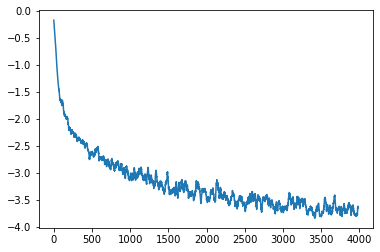

In [33]:
#plot loss curve
plt.plot(torch.log(F.avg_pool1d(run_loss.view(1,1,-1),15,stride=1).squeeze()));
plt.show()

In [32]:
#preload a trained model
torch.save({'backbone':backbone.cpu().state_dict(),'aspp':aspp.cpu().state_dict(),'head':head.cpu().state_dict(),},\
          'mobile_aspp2_3d_verse_edge_iso_128_patch_4k.pth')


In [12]:
cp = torch.load('mobile_aspp2_3d_verse_edge_iso_128_patch_4k.pth')
backbone.load_state_dict(cp['backbone'])
aspp.load_state_dict(cp['aspp'])
head.load_state_dict(cp['head'])

<All keys matched successfully>

In [13]:
validation_dataset = VerSe_Dataset(root_dir='/share/data_zoe1/hempe/data/VerSeV2/preprocessed19/iso_15_val', \
                                 transform=transforms.Compose([
                                    ZeroPad(132),
                                    ToTensor()]))

In [14]:
#evaluate segmentation accuracy: Dice Score
def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

#evaluate localisation accuracy: Centre-Mass distance to ground-truth in voxel
def loc_distance(label, predict):
    ##label
    Dl, Hl, Wl = label.squeeze(0).shape
    onehotlabel  = F.one_hot(label.long(),26)

    x = torch.linspace(0,1,Dl)
    centre_mass_z = (x.view(-1,1,1,1)*onehotlabel[0]).sum([0,1,2])/onehotlabel[0].sum([0,1,2])*Dl
    x = torch.linspace(0,1,Hl)
    centre_mass_y = (x.view(1,-1,1,1)*onehotlabel[0]).sum([0,1,2])/onehotlabel[0].sum([0,1,2])*Hl
    x = torch.linspace(0,1,Wl)
    centre_mass_x = (x.view(1,1,-1,1)*onehotlabel[0]).sum([0,1,2])/onehotlabel[0].sum([0,1,2])*Wl

    centres = np.array([np.array(centre_mass_z[1:]),np.array(centre_mass_y[1:]), np.array(centre_mass_x[1:])])

    ##prediction
    onehotpredict  = F.one_hot(predict.long(),26)
    Dp, Hp, Wp = label.squeeze(0).shape

    x = torch.linspace(0,1,Dp)
    centre_mass_z_pred = (x.view(-1,1,1,1)*onehotpredict[0]).sum([0,1,2])/onehotpredict[0].sum([0,1,2])*Dp
    x = torch.linspace(0,1,Hp)
    centre_mass_y_pred = (x.view(1,-1,1,1)*onehotpredict[0]).sum([0,1,2])/onehotpredict[0].sum([0,1,2])*Hp
    x = torch.linspace(0,1,Wp)
    centre_mass_x_pred = (x.view(1,1,-1,1)*onehotpredict[0]).sum([0,1,2])/onehotpredict[0].sum([0,1,2])*Wp

    centres_pred = np.array([np.array(centre_mass_z_pred[1:]),np.array(centre_mass_y_pred[1:]), np.array(centre_mass_x_pred[1:])])
    
    dist = np.sqrt(np.sum((centres-centres_pred)*(centres-centres_pred), axis=0))

    return dist

In [ ]:
#Test for one complete img
head.eval()
head.cuda()
backbone.eval()
backbone.cuda()
aspp.eval()
aspp.cuda()

index = 0
sample = validation_dataset[index]
image = sample["image"]
label = sample["label"]
C,D,H,W = image.shape


#apply some padding to ensure that the dimensions match for different image sizes
new_D = D + 4 - D%4
new_H = H + 4 - H%4
new_W = W + 4 - W%4
pad_img = torch.zeros((1,new_D,new_H,new_W))
pad_lab = torch.zeros((1,new_D,new_H,new_W))
test = pad_img[:,:D,:H,:W]
pad_img[:,:D,:H,:W] = image
pad_lab[:,:D,:H,:W] = label
    
with torch.no_grad():
    x1 = backbone[:2](pad_img.cuda().unsqueeze(0).float())
    y = aspp(backbone[2:](x1))
    y = torch.cat((x1,F.interpolate(y,scale_factor=2)),1)
    output = F.interpolate(checkpoint(head,y),scale_factor=2,mode='trilinear')
    predict = output.argmax(1).cpu().data
    
d = dice_coeff(predict.cpu().contiguous(), pad_lab.cpu().contiguous(), 26)
d_bin = dice_coeff(((torch.softmax(output,1)[:,0:1])<0.5).cpu().data,torch.clamp(pad_lab.cpu().data,0,1),2)
d_ident = dice_coeff(pad_lab.cpu().data, pad_lab.cpu().data,26)
dist = loc_distance(pad_lab, predict)